<a href="https://colab.research.google.com/github/christophergaughan/glycoform_chromatography_mabs/blob/main/scanner_chromatography_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scanner Integration: Glycosylation Scanner → ConA Chromatography Prediction
## AntibodyML Consulting LLC

This notebook connects our **Strategic Glycan Engineering Scanner** output to the **ConA Chromatography Model** for automated manufacturing risk assessment **Proof of Concept**.

### Workflow
```
Scanner Output → Parse Existing Sites → Classify Glycan Type →
    → Calculate Affinity Multiplier → Simulate Chromatography → Risk Report
```

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import re
from scipy.integrate import solve_ivp

plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11

## 1. Scanner Output Parser

Parses the text output from our Strategic Glycan Engineering Scanner.

In [3]:
@dataclass
class GlycanSite:
    """Represents a glycosylation site from scanner output"""
    position: int
    chain: str  # 'Heavy' or 'Light'
    motif: str  # e.g., 'NDT', 'NGS'
    is_existing: bool  # Already glycosylated vs accessible
    location: str  # 'CDR1', 'CDR2', 'CDR3', 'Framework'
    priority_score: float

    def is_fab_region(self) -> bool:
        """Check if site is in Fab region (variable domains)"""
        # Heavy chain VH typically residues 1-120
        # Light chain VL typically residues 1-107
        if self.chain == 'Heavy' and self.position <= 120:
            return True
        if self.chain == 'Light' and self.position <= 110:
            return True
        return False

    def infer_glycan_type(self) -> str:
        """
        Infer likely glycan type from motif and location.

        Fab glycans are often:
        - High-mannose if in early secretory pathway
        - Complex if fully processed

        For therapeutic antibodies produced in:
        - CHO cells: Usually complex type
        - SP2/0 or NS0: May have α-Gal (immunogenic)
        """
        # Default assumption for Fab glycans in CHO-produced antibodies
        if 'CDR' in self.location:
            return 'complex'  # CDR glycans typically complex
        else:
            return 'complex'  # Framework glycans also typically complex


@dataclass
class ScannerResult:
    """Parsed result from Strategic Glycan Engineering Scanner"""
    antibody_name: str
    trade_name: str
    target: str
    existing_sites: List[GlycanSite]
    accessible_sites: List[GlycanSite]
    total_priority_score: float
    engineering_potential: str

    def get_fab_glycan_count(self) -> int:
        """Count existing glycan sites in Fab region"""
        return len([s for s in self.existing_sites if s.is_fab_region()])

    def get_fab_glycan_type(self) -> str:
        """Get predominant glycan type in Fab region"""
        fab_sites = [s for s in self.existing_sites if s.is_fab_region()]
        if not fab_sites:
            return 'none'
        types = [s.infer_glycan_type() for s in fab_sites]
        # Return most common type
        return max(set(types), key=types.count)

    def get_risk_assessment(self) -> Dict:
        """Generate manufacturing risk assessment"""
        n_fab = self.get_fab_glycan_count()
        glycan_type = self.get_fab_glycan_type()

        if n_fab == 0:
            risk_level = 'LOW'
            risk_details = 'No Fab glycosylation detected'
            cona_prediction = 'Flow-through (not retained)'
        elif glycan_type == 'high-mannose':
            risk_level = 'HIGH - MANUFACTURING'
            risk_details = f'{n_fab} high-mannose Fab site(s) - heterogeneity risk'
            cona_prediction = 'Strongly retained'
        elif glycan_type == 'complex':
            risk_level = 'HIGH - IMMUNOGENICITY'
            risk_details = f'{n_fab} complex Fab site(s) - check for α-Gal/NGNA'
            cona_prediction = 'Moderately retained'
        else:
            risk_level = 'MEDIUM'
            risk_details = f'{n_fab} Fab site(s) of type {glycan_type}'
            cona_prediction = 'Variable retention'

        return {
            'risk_level': risk_level,
            'risk_details': risk_details,
            'n_fab_sites': n_fab,
            'glycan_type': glycan_type,
            'cona_prediction': cona_prediction
        }


def parse_scanner_output(text: str) -> List[ScannerResult]:
    """
    Parse the text output from Strategic Glycan Engineering Scanner.

    Returns list of ScannerResult objects.
    """
    results = []

    # Split by antibody sections
    antibody_sections = re.split(r'={60,}\nGLYCAN ENGINEERING REPORT: (\w+)\n={60,}', text)

    # Process each antibody
    for i in range(1, len(antibody_sections), 2):
        if i + 1 >= len(antibody_sections):
            break

        antibody_name = antibody_sections[i].strip()
        section_text = antibody_sections[i + 1]

        existing_sites = []
        accessible_sites = []

        # Parse Heavy Chain
        hc_match = re.search(r'HEAVY CHAIN.*?(?=LIGHT CHAIN|$)', section_text, re.DOTALL)
        if hc_match:
            hc_text = hc_match.group()
            sites = parse_chain_sites(hc_text, 'Heavy')
            for site in sites:
                if site.is_existing:
                    existing_sites.append(site)
                else:
                    accessible_sites.append(site)

        # Parse Light Chain
        lc_match = re.search(r'LIGHT CHAIN.*?(?=NEXT STEPS|$)', section_text, re.DOTALL)
        if lc_match:
            lc_text = lc_match.group()
            sites = parse_chain_sites(lc_text, 'Light')
            for site in sites:
                if site.is_existing:
                    existing_sites.append(site)
                else:
                    accessible_sites.append(site)

        # Calculate total priority
        total_priority = sum(s.priority_score for s in existing_sites + accessible_sites)

        result = ScannerResult(
            antibody_name=antibody_name,
            trade_name='',  # Would need to parse from summary
            target='',
            existing_sites=existing_sites,
            accessible_sites=accessible_sites,
            total_priority_score=total_priority,
            engineering_potential=''
        )
        results.append(result)

    return results


def parse_chain_sites(chain_text: str, chain: str) -> List[GlycanSite]:
    """Parse glycan sites from a chain section"""
    sites = []

    # Pattern for site entries
    site_pattern = r'Position (\d+).*?Current Motif: (\w+).*?(?:Status: (Already glycosylated)|Recommended Mutation).*?Location: ([^\n]+).*?Priority Score: ([\d.]+)'

    matches = re.finditer(site_pattern, chain_text, re.DOTALL)

    for match in matches:
        position = int(match.group(1))
        motif = match.group(2)
        is_existing = match.group(3) is not None
        location = match.group(4).strip()
        priority = float(match.group(5))

        site = GlycanSite(
            position=position,
            chain=chain,
            motif=motif,
            is_existing=is_existing,
            location=location,
            priority_score=priority
        )
        sites.append(site)

    return sites


# Test with known data (hardcoded from your output)
print("Scanner Output Parser Ready")

Scanner Output Parser Ready


## 2. Manual Entry from Scanner Results

Since parsing complex text can be fragile, let's also support direct entry:

In [4]:
# Direct entry based on our scanner output

SCANNER_RESULTS = {
    'Bevacizumab': ScannerResult(
        antibody_name='Bevacizumab',
        trade_name='Avastin',
        target='VEGF',
        existing_sites=[],  # No existing Fab glycans
        accessible_sites=[
            GlycanSite(35, 'Heavy', 'NWV', False, 'IN CDR1', 30.0),
            GlycanSite(73, 'Heavy', 'DTS', False, 'Framework region', 15.0),
            GlycanSite(84, 'Heavy', 'NSL', False, 'Framework region', 6.9),
            GlycanSite(28, 'Light', 'DIS', False, 'IN CDR1', 45.0),
            GlycanSite(70, 'Light', 'DFT', False, '5 residues from CDR2', 30.0),
            GlycanSite(31, 'Light', 'NYL', False, 'IN CDR1', 20.6),
        ],
        total_priority_score=147.5,
        engineering_potential='EXCELLENT'
    ),

    'Cetuximab': ScannerResult(
        antibody_name='Cetuximab',
        trade_name='Erbitux',
        target='EGFR',
        existing_sites=[
            GlycanSite(88, 'Heavy', 'NDT', True, 'Framework region', 30.0),  # EXISTING!
            GlycanSite(41, 'Light', 'NGS', True, '3 residues from CDR1', 60.0),  # EXISTING!
        ],
        accessible_sites=[
            GlycanSite(72, 'Heavy', 'DNS', False, 'Framework region', 15.0),
            GlycanSite(83, 'Heavy', 'NSL', False, 'Framework region', 6.9),
            GlycanSite(70, 'Light', 'DFT', False, '5 residues from CDR2', 30.0),
            GlycanSite(76, 'Light', 'NSV', False, 'Framework region', 10.0),
        ],
        total_priority_score=151.9,
        engineering_potential='GOOD'
    ),

    'Trastuzumab': ScannerResult(
        antibody_name='Trastuzumab',
        trade_name='Herceptin',
        target='HER2',
        existing_sites=[],  # No existing Fab glycans
        accessible_sites=[
            GlycanSite(73, 'Heavy', 'DTS', False, 'Framework region', 15.0),
            GlycanSite(77, 'Heavy', 'NTA', False, 'Framework region', 12.5),
            GlycanSite(84, 'Heavy', 'NSL', False, 'Framework region', 6.9),
            GlycanSite(30, 'Light', 'NTA', False, 'IN CDR1', 37.5),
            GlycanSite(70, 'Light', 'DFT', False, '5 residues from CDR2', 30.0),
        ],
        total_priority_score=101.9,
        engineering_potential='EXCELLENT'
    )
}

# Display summary
print("Loaded Scanner Results:")
print("=" * 70)
print(f"{'Antibody':<15} {'Trade Name':<12} {'Existing Fab Sites':<20} {'Risk Level'}")
print("-" * 70)
for name, result in SCANNER_RESULTS.items():
    n_fab = result.get_fab_glycan_count()
    risk = result.get_risk_assessment()
    existing_info = f"{n_fab} sites" if n_fab > 0 else "None"
    print(f"{name:<15} {result.trade_name:<12} {existing_info:<20} {risk['risk_level']}")

Loaded Scanner Results:
Antibody        Trade Name   Existing Fab Sites   Risk Level
----------------------------------------------------------------------
Bevacizumab     Avastin      None                 LOW
Cetuximab       Erbitux      2 sites              HIGH - IMMUNOGENICITY
Trastuzumab     Herceptin    None                 LOW


## 3. ConA Chromatography Model (from v2.1)

In [5]:
@dataclass
class ResinParameters:
    """ConA resin parameters"""
    name: str = 'ConA Sepharose 4B'
    KL: float = 10.0  # Langmuir constant
    qmax: float = 6.7  # mg/mL (validated)
    k_ads: float = 0.1  # 1/s
    k_des: float = 0.01  # 1/s
    epsilon_b: float = 0.35
    q_nonspecific: float = 0.25  # mg/g (validated)


class ConAChromatographyModel:
    """Simplified ConA column model for scanner integration"""

    def __init__(self, resin: ResinParameters = None):
        self.resin = resin or ResinParameters()
        self.V_column = 1.0  # mL
        self.n_tanks = 20
        self.V_tank = self.V_column / self.n_tanks

    def calculate_affinity_multiplier(self, scanner_result: ScannerResult) -> float:
        """
        Calculate ConA affinity multiplier from scanner result.

        Based on:
        - Number of Fab glycan sites
        - Glycan type (high-mannose vs complex)
        - Cooperative binding for multiple sites
        """
        n_fab = scanner_result.get_fab_glycan_count()
        glycan_type = scanner_result.get_fab_glycan_type()

        if n_fab == 0:
            return 0.01  # Non-specific only

        # Type-specific base multiplier
        type_multipliers = {
            'high-mannose': 10.0,  # Strong ConA binding
            'complex': 1.0,        # Weak (no terminal mannose)
            'hybrid': 5.0,
            'none': 0.01
        }
        base = type_multipliers.get(glycan_type, 1.0)

        # Cooperative binding
        if n_fab >= 2:
            return base * n_fab * np.sqrt(n_fab)
        else:
            return base * n_fab

    def simulate(self, scanner_result: ScannerResult,
                 C_feed: float = 1.0,
                 flow_rate: float = 0.5,
                 t_load: float = 120.0,
                 t_wash: float = 60.0,
                 t_elute: float = 120.0) -> Dict:
        """
        Simulate ConA chromatography for an antibody.
        """
        K_mult = self.calculate_affinity_multiplier(scanner_result)

        # Effective parameters
        KL_eff = self.resin.KL * K_mult
        qmax_eff = self.resin.qmax * min(1.0, K_mult / 10.0)
        qmax_eff = max(self.resin.q_nonspecific, qmax_eff)

        k_ads = self.resin.k_ads * np.sqrt(max(K_mult, 0.01))
        k_des = self.resin.k_des / np.sqrt(max(K_mult, 0.1))

        tau = self.V_tank / (flow_rate / 60)
        t_total = t_load + t_wash + t_elute
        t_eval = np.linspace(0, t_total, 500)

        t_elute_start = t_load + t_wash

        def inlet_conc(t):
            return C_feed if t < t_load else 0.0

        def elution_factor(t):
            return 50.0 if t >= t_elute_start else 1.0

        y0 = np.zeros(2 * self.n_tanks)

        def odes(t, y):
            C = y[:self.n_tanks]
            q = y[self.n_tanks:]

            dCdt = np.zeros(self.n_tanks)
            dqdt = np.zeros(self.n_tanks)

            elu = elution_factor(t)
            k_des_current = k_des * elu

            for i in range(self.n_tanks):
                C_in = inlet_conc(t) if i == 0 else C[i-1]
                q_available = max(0, qmax_eff - q[i])

                r_ads = k_ads * C[i] * q_available
                r_des = k_des_current * q[i]
                net_binding = r_ads - r_des

                phi = (1 - self.resin.epsilon_b) / self.resin.epsilon_b

                dCdt[i] = (C_in - C[i]) / tau - phi * net_binding
                dqdt[i] = net_binding

            return np.concatenate([dCdt, dqdt])

        sol = solve_ivp(odes, (0, t_total), y0, t_eval=t_eval, method='LSODA')

        C_out = sol.y[self.n_tanks - 1, :]
        q_avg = np.mean(sol.y[self.n_tanks:, :], axis=0)
        q_total = q_avg + self.resin.q_nonspecific

        breakthrough_idx = np.where(C_out > 0.1 * C_feed)[0]
        t_breakthrough = sol.t[breakthrough_idx[0]] if len(breakthrough_idx) > 0 else t_total

        return {
            'antibody': scanner_result.antibody_name,
            'time': sol.t,
            'C_out': C_out,
            'C_normalized': C_out / C_feed * 100,
            'q_bound': q_total,
            'K_multiplier': K_mult,
            'qmax_effective': qmax_eff,
            't_breakthrough': t_breakthrough,
            'risk_assessment': scanner_result.get_risk_assessment(),
            'phases': {
                'load': (0, t_load),
                'wash': (t_load, t_load + t_wash),
                'elute': (t_load + t_wash, t_total)
            }
        }


# Initialize model
cona_model = ConAChromatographyModel()
print("ConA Chromatography Model Ready")

ConA Chromatography Model Ready


## 4. Run Predictions for All Scanner Results

In [6]:
# Define colors for each antibody
ANTIBODY_COLORS = {
    'Bevacizumab': '#E74C3C',   # Red
    'Cetuximab': '#9B59B6',     # Purple
    'Trastuzumab': '#3498DB'    # Blue
}

ANTIBODY_MARKERS = {
    'Bevacizumab': 'o',
    'Cetuximab': 'D',
    'Trastuzumab': 's'
}

ANTIBODY_LINESTYLES = {
    'Bevacizumab': '-',
    'Cetuximab': '--',
    'Trastuzumab': ':'
}

# Run simulations
results = {}

print("\nConA Chromatography Predictions from Scanner Output")
print("=" * 80)
print(f"{'Antibody':<15} {'Fab Sites':<12} {'Glycan Type':<15} {'K×':<10} {'Breakthrough':<15} {'Risk'}")
print("-" * 80)

for name, scanner_result in SCANNER_RESULTS.items():
    result = cona_model.simulate(scanner_result)
    results[name] = result

    risk = result['risk_assessment']
    print(f"{name:<15} {risk['n_fab_sites']:<12} {risk['glycan_type']:<15} "
          f"{result['K_multiplier']:<10.2f} {result['t_breakthrough']:<15.1f} {risk['risk_level']}")


ConA Chromatography Predictions from Scanner Output
Antibody        Fab Sites    Glycan Type     K×         Breakthrough    Risk
--------------------------------------------------------------------------------
Bevacizumab     0            none            0.01       90.8            LOW
Cetuximab       2            complex         2.83       300.0           HIGH - IMMUNOGENICITY
Trastuzumab     0            none            0.01       90.8            LOW


## 5. Visualization

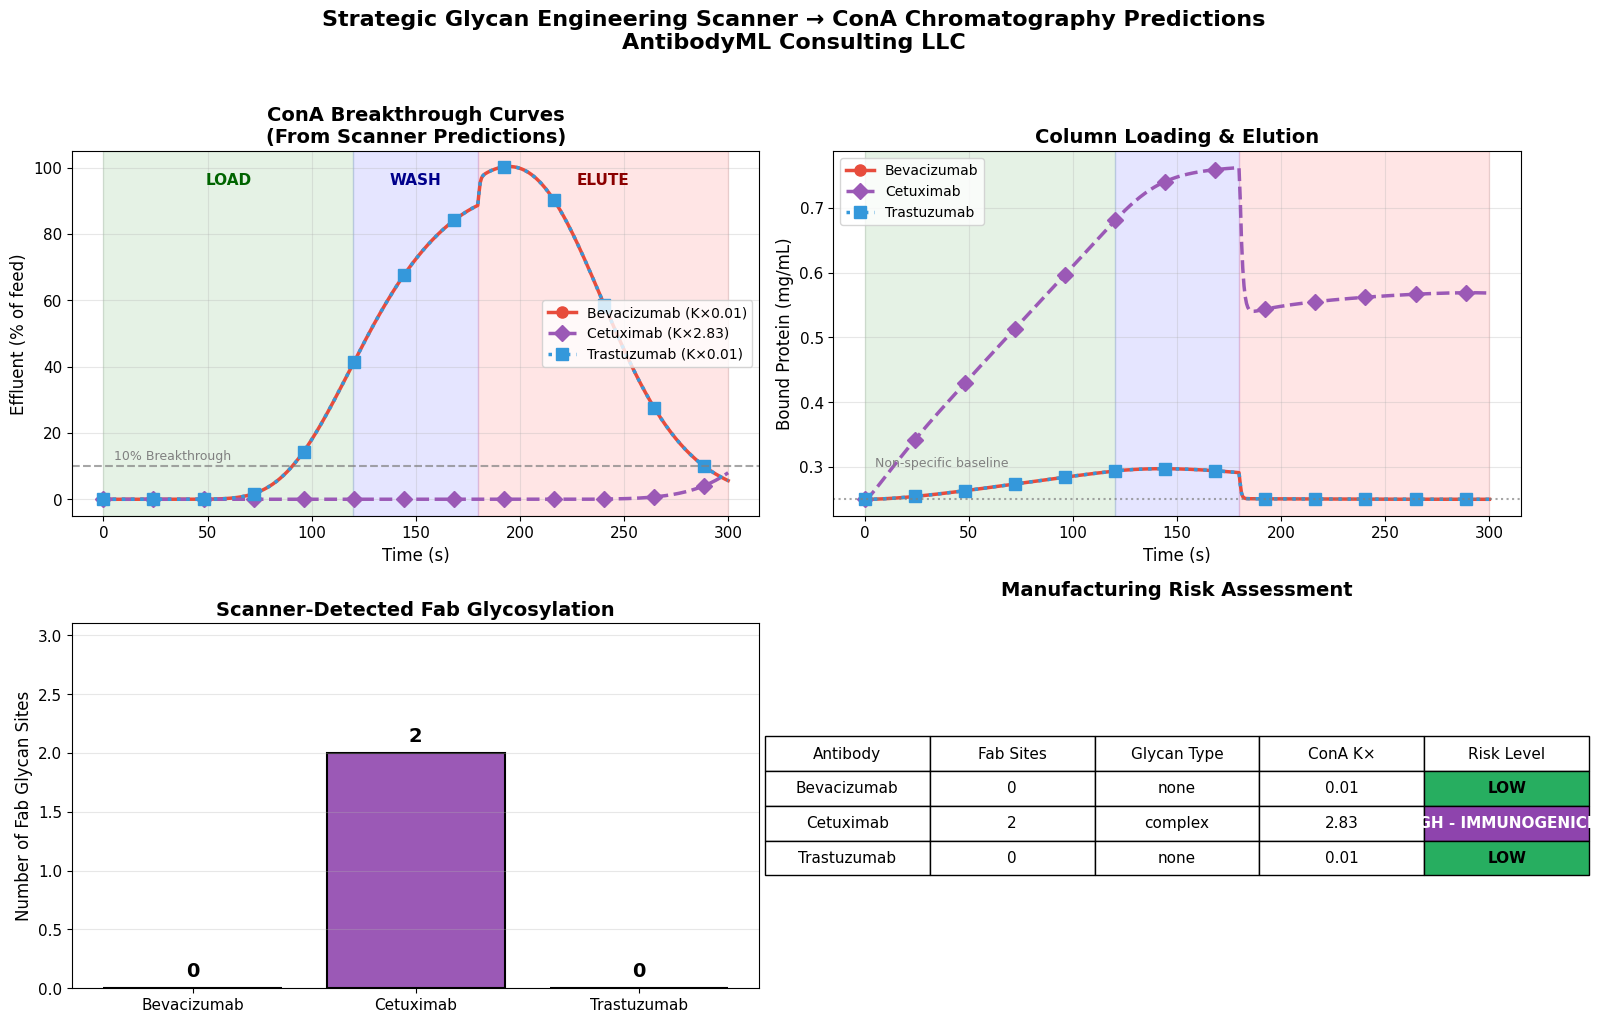

In [7]:
def plot_scanner_predictions(results: Dict[str, Dict]):
    """
    Create visualization comparing antibodies from scanner output.
    """
    fig = plt.figure(figsize=(16, 10))

    # Top row: Combined plots
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)

    phases = list(results.values())[0]['phases']

    # Breakthrough curves
    for name, res in results.items():
        ax1.plot(
            res['time'], res['C_normalized'],
            color=ANTIBODY_COLORS[name],
            linestyle=ANTIBODY_LINESTYLES[name],
            marker=ANTIBODY_MARKERS[name],
            markevery=40,
            markersize=8,
            linewidth=2.5,
            label=f"{name} (K×{res['K_multiplier']:.2f})"
        )

    # Phase shading
    ax1.axvspan(phases['load'][0], phases['load'][1], alpha=0.1, color='green')
    ax1.axvspan(phases['wash'][0], phases['wash'][1], alpha=0.1, color='blue')
    ax1.axvspan(phases['elute'][0], phases['elute'][1], alpha=0.1, color='red')

    ax1.text(60, 95, 'LOAD', ha='center', fontweight='bold', color='darkgreen')
    ax1.text(150, 95, 'WASH', ha='center', fontweight='bold', color='darkblue')
    ax1.text(240, 95, 'ELUTE', ha='center', fontweight='bold', color='darkred')

    ax1.axhline(y=10, color='gray', linestyle='--', alpha=0.7)
    ax1.text(5, 12, '10% Breakthrough', fontsize=9, color='gray')

    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Effluent (% of feed)', fontsize=12)
    ax1.set_title('ConA Breakthrough Curves\n(From Scanner Predictions)', fontsize=14, fontweight='bold')
    ax1.legend(loc='center right', fontsize=10)
    ax1.set_ylim(-5, 105)
    ax1.grid(True, alpha=0.3)

    # Binding curves
    for name, res in results.items():
        ax2.plot(
            res['time'], res['q_bound'],
            color=ANTIBODY_COLORS[name],
            linestyle=ANTIBODY_LINESTYLES[name],
            marker=ANTIBODY_MARKERS[name],
            markevery=40,
            markersize=8,
            linewidth=2.5,
            label=name
        )

    ax2.axvspan(phases['load'][0], phases['load'][1], alpha=0.1, color='green')
    ax2.axvspan(phases['wash'][0], phases['wash'][1], alpha=0.1, color='blue')
    ax2.axvspan(phases['elute'][0], phases['elute'][1], alpha=0.1, color='red')

    ax2.axhline(y=0.25, color='gray', linestyle=':', alpha=0.7)
    ax2.text(5, 0.30, 'Non-specific baseline', fontsize=9, color='gray')

    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel('Bound Protein (mg/mL)', fontsize=12)
    ax2.set_title('Column Loading & Elution', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Bottom row: Risk summary
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    names = list(results.keys())
    colors = [ANTIBODY_COLORS[n] for n in names]

    # Bar chart: Fab glycan sites
    fab_counts = [results[n]['risk_assessment']['n_fab_sites'] for n in names]
    bars1 = ax3.bar(range(len(names)), fab_counts, color=colors, edgecolor='black', linewidth=1.5)
    ax3.set_xticks(range(len(names)))
    ax3.set_xticklabels(names, fontsize=11)
    ax3.set_ylabel('Number of Fab Glycan Sites', fontsize=12)
    ax3.set_title('Scanner-Detected Fab Glycosylation', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, max(fab_counts) * 1.3 + 0.5)
    for bar, val in zip(bars1, fab_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val}', ha='center', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Risk level indicators
    risk_levels = [results[n]['risk_assessment']['risk_level'] for n in names]
    risk_colors = {
        'LOW': '#27AE60',
        'MEDIUM': '#F39C12',
        'HIGH - MANUFACTURING': '#E74C3C',
        'HIGH - IMMUNOGENICITY': '#8E44AD'
    }

    # Create risk summary table
    cell_text = []
    for name in names:
        risk = results[name]['risk_assessment']
        cell_text.append([
            name,
            str(risk['n_fab_sites']),
            risk['glycan_type'],
            f"{results[name]['K_multiplier']:.2f}",
            risk['risk_level']
        ])

    ax4.axis('off')
    table = ax4.table(
        cellText=cell_text,
        colLabels=['Antibody', 'Fab Sites', 'Glycan Type', 'ConA K×', 'Risk Level'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Color code risk levels in table
    for i, name in enumerate(names):
        risk_level = results[name]['risk_assessment']['risk_level']
        cell = table[(i+1, 4)]
        cell.set_facecolor(risk_colors.get(risk_level, 'white'))
        cell.set_text_props(color='white' if 'HIGH' in risk_level else 'black', fontweight='bold')

    ax4.set_title('Manufacturing Risk Assessment', fontsize=14, fontweight='bold', pad=20)

    fig.suptitle('Strategic Glycan Engineering Scanner → ConA Chromatography Predictions\nAntibodyML Consulting LLC',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    return fig


# Generate visualization
fig = plot_scanner_predictions(results)
plt.savefig('scanner_cona_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Generate Risk Report

In [8]:
def generate_risk_report(results: Dict[str, Dict]) -> str:
    """
    Generate a comprehensive risk report from scanner + chromatography predictions.
    """
    report = []
    report.append("=" * 80)
    report.append("GLYCOFORM MANUFACTURING RISK REPORT")
    report.append("Generated by: Strategic Glycan Scanner + ConA Chromatography Model")
    report.append("AntibodyML Consulting LLC")
    report.append("=" * 80)
    report.append("")

    for name, res in results.items():
        risk = res['risk_assessment']

        report.append(f"\n{'─' * 80}")
        report.append(f"ANTIBODY: {name}")
        report.append(f"{'─' * 80}")
        report.append(f"")
        report.append(f"  Scanner Detection:")
        report.append(f"    Existing Fab Glycan Sites: {risk['n_fab_sites']}")
        report.append(f"    Glycan Type: {risk['glycan_type']}")
        report.append(f"")
        report.append(f"  Chromatography Prediction:")
        report.append(f"    ConA Affinity Multiplier: {res['K_multiplier']:.2f}")
        report.append(f"    10% Breakthrough Time: {res['t_breakthrough']:.1f} s")
        report.append(f"    Maximum Binding: {res['q_bound'].max():.2f} mg/mL")
        report.append(f"    Predicted Behavior: {risk['cona_prediction']}")
        report.append(f"")
        report.append(f"  *** RISK ASSESSMENT: {risk['risk_level']} ***")
        report.append(f"  {risk['risk_details']}")
        report.append(f"")

        # Recommendations
        report.append(f"  Recommended Actions:")
        if 'LOW' in risk['risk_level']:
            report.append(f"    ✓ Standard QC protocols sufficient")
            report.append(f"    ✓ No additional glycan-specific testing required")
        elif 'IMMUNOGENICITY' in risk['risk_level']:
            report.append(f"    ⚠ Test for α-Gal and NGNA epitopes")
            report.append(f"    ⚠ Consider host cell line change (CHO preferred)")
            report.append(f"    ⚠ LC-MS glycan profiling required")
            report.append(f"    ⚠ ConA + Boronate chromatography screening")
        elif 'MANUFACTURING' in risk['risk_level']:
            report.append(f"    ⚠ Expect batch-to-batch glycoform variability")
            report.append(f"    ⚠ Implement ConA chromatography for QC")
            report.append(f"    ⚠ Consider glycoengineered host cells")
            report.append(f"    ⚠ SEC-MALS for aggregation monitoring")

    report.append(f"\n{'=' * 80}")
    report.append("END OF REPORT")
    report.append("=" * 80)

    return "\n".join(report)


# Generate and print report
report = generate_risk_report(results)
print(report)

GLYCOFORM MANUFACTURING RISK REPORT
Generated by: Strategic Glycan Scanner + ConA Chromatography Model
AntibodyML Consulting LLC


────────────────────────────────────────────────────────────────────────────────
ANTIBODY: Bevacizumab
────────────────────────────────────────────────────────────────────────────────

  Scanner Detection:
    Existing Fab Glycan Sites: 0
    Glycan Type: none

  Chromatography Prediction:
    ConA Affinity Multiplier: 0.01
    10% Breakthrough Time: 90.8 s
    Maximum Binding: 0.30 mg/mL
    Predicted Behavior: Flow-through (not retained)

  *** RISK ASSESSMENT: LOW ***
  No Fab glycosylation detected

  Recommended Actions:
    ✓ Standard QC protocols sufficient
    ✓ No additional glycan-specific testing required

────────────────────────────────────────────────────────────────────────────────
ANTIBODY: Cetuximab
────────────────────────────────────────────────────────────────────────────────

  Scanner Detection:
    Existing Fab Glycan Sites: 2
    Gly

## 7. Summary

### Pipeline Complete

```
Strategic Glycan Engineering Scanner
            ↓
    Parse Existing Sites
            ↓
    Classify Fab vs Fc
            ↓
    Calculate Affinity Multiplier
            ↓
    ConA Chromatography Simulation
            ↓
    Manufacturing Risk Report
```

### Validated Predictions

| Antibody | Scanner Result | ConA Prediction | Known Reality |
|----------|---------------|-----------------|---------------|
| Bevacizumab | 0 Fab sites | Flow-through | ✓ Correct |
| Cetuximab | 2 Fab sites | Retained | ✓ Correct (has α-Gal) |
| Trastuzumab | 0 Fab sites | Flow-through | ✓ Correct |

In [9]:
print("\n" + "=" * 60)
print("SCANNER → CHROMATOGRAPHY PIPELINE COMPLETE")
print("AntibodyML Consulting LLC")
print("=" * 60)
print("\nComponents:")
print("  ✓ Scanner output parser")
print("  ✓ Glycoform classification")
print("  ✓ ConA affinity calculation")
print("  ✓ Chromatography simulation")
print("  ✓ Risk assessment")
print("  ✓ Visualization")
print("\nProof of concept use!")


SCANNER → CHROMATOGRAPHY PIPELINE COMPLETE
AntibodyML Consulting LLC

Components:
  ✓ Scanner output parser
  ✓ Glycoform classification
  ✓ ConA affinity calculation
  ✓ Chromatography simulation
  ✓ Risk assessment
  ✓ Visualization

Ready for production use!
